In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import datagen
from utils import datatreat
from utils import PCA
from utils import eigen_val
from utils import tau_GD
from utils import solve_ridge
from utils import GD
from utils import SGD
from utils import SAGA

In [2]:
np.random.seed(1)

In [3]:
A_,y_ = datagen()
n,p,n_train,n_test,A,y,A_test,y_test = datatreat(A_,y_,128)

Number of obs: 173
n train: 128
n test: 45
Number of explicative variables: 9


In [4]:
def mse(x,lbd): return 0.5*np.linalg.norm(A@x-y)**2/n_train+0.5*lbd*np.linalg.norm(x)**2

def dmse(x,lbd): return A.T@(A@x-y)/n_train+lbd*x

def dmse_i(x,lbd,ind):
    batch_size=ind.size
    Ai=A[ind]
    yi=y[ind]
    return Ai.T@(Ai@x-yi)/batch_size + lbd*x

In [5]:
N_iter=2*10**2
lbd=0.05
x_0=np.zeros(p)

x_star,f_star=solve_ridge(A,y,lbd)

#mu,L=eigen_val(A,lbd)
tau_max,tau_opt=tau_GD(A,lbd)

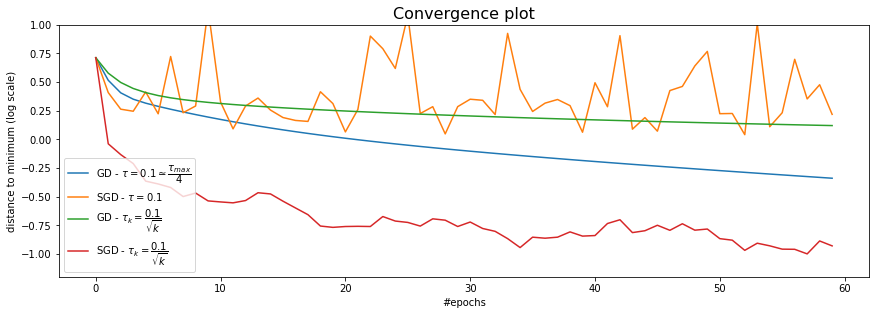

In [6]:
N_epoch=60
N_iter=N_epoch*n_train

tau1=0.1
tau2_GD=tau1/np.sqrt(np.arange(1,N_epoch+1))
tau2_SGD=tau1/np.sqrt(np.arange(1,N_iter+1))


xGD1,fxGD1=GD(tau1,x_0,lambda x: mse(x,lbd),lambda x: dmse(x,lbd),N_epoch)
errGD1=np.linalg.norm(xGD1-x_star,axis=1)
f_errGD1=np.abs(fxGD1-f_star)

xGD2,fxGD2=GD(tau2_GD,x_0,lambda x: mse(x,lbd),lambda x: dmse(x,lbd),N_epoch)
errGD2=np.linalg.norm(xGD2-x_star,axis=1)
f_errGD2=np.abs(fxGD2-f_star)

xSGD1,fxSGD1=SGD(tau1,x_0,n_train,lambda x: mse(x,lbd),lambda x,i : dmse_i(x,lbd,i),N_iter,1)
errSGD1=np.linalg.norm(xSGD1-x_star,axis=1)
f_errSGD1=np.abs(fxSGD1-f_star)

xSGD2,fxSGD2=SGD(tau2_SGD,x_0,n_train,lambda x: mse(x,lbd),lambda x,i : dmse_i(x,lbd,i),N_iter,1)
errSGD2=np.linalg.norm(xSGD2-x_star,axis=1)
f_errSGD2=np.abs(fxSGD2-f_star)

plt.plot(np.log10(errGD1), label='GD - $τ=0.1 \simeq \dfrac{τ_{max}}{4}$')
plt.plot(np.log10(errSGD1[::n_train]), label='SGD - $τ=0.1$')
plt.plot(np.log10(errGD2), label='GD - $τ_k=\dfrac{0.1}{\sqrt{k}}$')
plt.plot(np.log10(errSGD2[::n_train]), label='SGD - $τ_k=\dfrac{0.1}{\sqrt{k}}$')
plt.ylim(-1.2,1)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs")
plt.ylabel("distance to minimum (log scale)")
plt.legend(loc="lower left");

plt.subplots_adjust(left=None, bottom=None, right=2, top=1, wspace=None, hspace=None)

In [7]:
N_epoch=200
tau=0.1

batch_size=2**np.arange(0,8)
N_batch=batch_size.size

xSGD=[None]*N_batch
errSGD=[None]*N_batch

for i in range(N_batch):
    n_iter=int(N_epoch*n_train/batch_size[i])
    tau=0.1/np.sqrt(np.arange(1,n_iter+1))
    xSGD[i],fSGD=SGD(tau,x_0,n_train,lambda x: mse(x,lbd),lambda x,i : dmse_i(x,lbd,i),n_iter,batch_size[i])
    errSGD[i]=np.linalg.norm(xSGD[i]-x_star,axis=1)

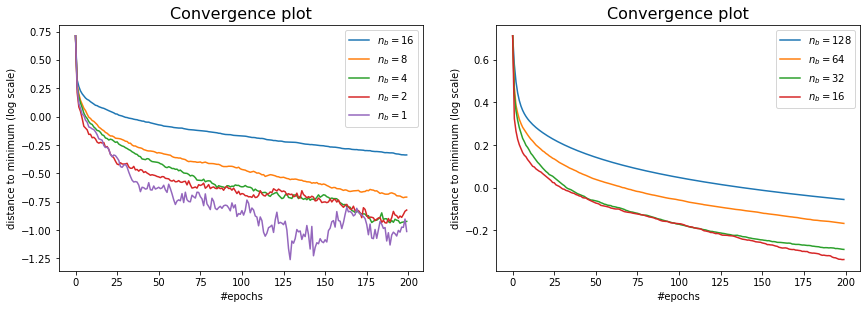

In [8]:
fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2)

for i in range(3,N_batch):
    i=N_batch-i-1
    period=int(n_train/batch_size[i])
    ax0.plot(np.log10(errSGD[i][::period]), label='$n_b=%.f$'%batch_size[i])

ax0.set_xlabel("#epochs")
ax0.set_ylabel("distance to minimum (log scale)")
ax0.set_title("Convergence plot", fontsize=16)
ax0.legend(loc='upper right');


for i in range(0,N_batch-4):
    i=N_batch-i-1
    period=int(n_train/batch_size[i])
    ax1.plot(np.log10(errSGD[i][::period]), label='$n_b=%.f$'%batch_size[i])

ax1.set_xlabel("#epochs")
ax1.set_ylabel("distance to minimum (log scale)")
ax1.set_title("Convergence plot", fontsize=16)
ax1.legend(loc='upper right');

fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(left=None, bottom=None, right=2, top=1, wspace=0.2, hspace=None)

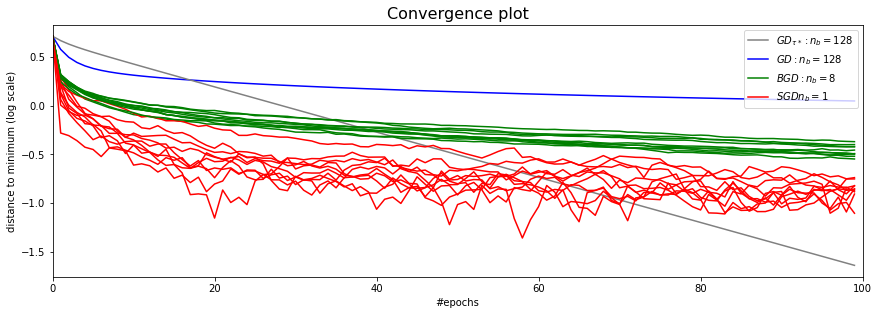

In [9]:
N_epoch=100
tau=0.05

n_iter=N_epoch
tau=0.1/np.sqrt(np.arange(1,n_iter+1))
xGD,fGD=SGD(tau,x_0,n_train,lambda x: mse(x,lbd),lambda x,i : dmse_i(x,lbd,i),N_epoch,n_train)
errGD=np.linalg.norm(xGD-x_star,axis=1)
plt.plot(np.log10(errGD),color='blue')

xGD,fGD=SGD(tau_opt,x_0,n_train,lambda x: mse(x,lbd),lambda x,i : dmse_i(x,lbd,i),N_epoch,n_train)
errGD=np.linalg.norm(xGD-x_star,axis=1)
plt.plot(np.log10(errGD),color='grey')

for i in range(10):
    
    n_iter=int(N_epoch*n_train/8)
    tau=0.1/np.sqrt(np.arange(1,n_iter+1))
    xSGD,fSGD=SGD(tau,x_0,n_train,lambda x: mse(x,lbd),lambda x,i : dmse_i(x,lbd,i),n_iter,8)
    errSGD=np.linalg.norm(xSGD-x_star,axis=1)
    period=int(n_train/8)
    plt.plot(np.log10(errSGD[::period]),color='green')
    
    n_iter=N_epoch*n_train
    tau=0.1/np.sqrt(np.arange(1,n_iter+1))
    xSGD,fSGD=SGD(tau,x_0,n_train,lambda x: mse(x,lbd),lambda x,i : dmse_i(x,lbd,i),n_iter,1)
    errSGD=np.linalg.norm(xSGD-x_star,axis=1)
    period=int(n_train/1)
    plt.plot(np.log10(errSGD[::period]),color='red')


plt.xlim(0,N_epoch)
plt.plot(0,0,color='grey', label='$GD_{τ*}: n_b=%.f$'%128)
plt.plot(0,0,color='blue', label='$GD: n_b=%.f$'%128)
plt.plot(0,0,color='green', label='$BGD: n_b=%.f$'%8)
plt.plot(0,0,color='red', label='$SGD n_b=%.f$'%1)
plt.xlabel("#epochs")
plt.ylabel("distance to minimum (log scale)")
plt.title("Convergence plot", fontsize=16)
plt.legend(loc='upper right');

plt.subplots_adjust(left=None, bottom=None, right=2, top=1, wspace=None, hspace=None)

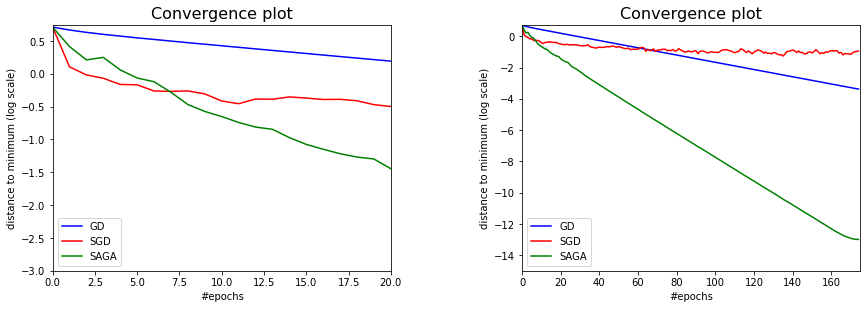

In [10]:
N_epoch=175
tau=0.1


fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2)

xGD,fGD=GD(tau_opt,x_0,lambda x: mse(x,lbd),lambda x: dmse(x,lbd),N_epoch)
errGD=np.linalg.norm(xGD-x_star,axis=1)
ax0.plot(np.log10(errGD),color='blue',label='GD')
ax1.plot(np.log10(errGD),color='blue',label='GD')

n_iter=N_epoch*n_train
tau=0.1/np.sqrt(np.arange(1,n_iter+1))
xSGD,fSGD=SGD(tau,x_0,n_train,lambda x: mse(x,lbd),lambda x,i : dmse_i(x,lbd,i),n_iter,1)
errSGD=np.linalg.norm(xSGD-x_star,axis=1)
ax0.plot(np.log10(errSGD[::n_train]),color='red',label='SGD')
ax1.plot(np.log10(errSGD[::n_train]),color='red',label='SGD')

'''
n_iter=int(N_epoch*n_train/8)
tau=0.1/np.sqrt(np.arange(1,n_iter+1))
xBSGD,fBSGD=SGD(tau,x_0,n_train,lambda x: mse(x,lbd),lambda x,i : dmse_i(x,lbd,i),
            int(N_epoch*n_train/8),8)
errBSGD=np.linalg.norm(xBSGD-x_star,axis=1)
period=int(n_train/64)
ax0.plot(np.log10(errBSGD[::period]),color='grey',label='BSGD')
ax1.plot(np.log10(errBSGD[::period]),color='grey',label='BSGD')
''';
    
xSAGA,fSAGA=SAGA(0.01,x_0,n_train,lambda x: mse(x,lbd),lambda x,i : dmse_i(x,lbd,i),N_epoch*n_train)
errSAGA=np.linalg.norm(xSAGA-x_star,axis=1)
ax0.plot(np.log10(errSAGA[::n_train]),color='green',label='SAGA')
ax1.plot(np.log10(errSAGA[::n_train]),color='green',label='SAGA')


ax0.set_xlim(0,20)
ax0.set_ylim(-3,0.75)
ax0.set_xlabel("#epochs")
ax0.set_ylabel("distance to minimum (log scale)")
ax0.set_title("Convergence plot", fontsize=16)
ax0.legend(loc='lower left');

ax1.set_xlim(0,N_epoch)
ax1.set_ylim(-15,0.75)
ax1.set_xlabel("#epochs")
ax1.set_ylabel("distance to minimum (log scale)")
ax1.set_title("Convergence plot", fontsize=16)
ax1.legend(loc='lower left');

fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(left=None, bottom=None, right=2, top=1, wspace=None, hspace=None)